In [1]:
# original library
from flex_tools import *

import numpy as np
import numpy.linalg as la
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import seaborn as sns

import gc
import sys
import time
from tqdm import tqdm
import mpi4py

from typing import Union, Optional, Callable
from dataclasses import dataclass
from IPython.display import display

### get_INTERACTION の挙動

In [2]:
Uinner = 1
Uinter = 10
Jhund =  100
Jpair = 1000

U_charge, U_spin = get_INTERACTION(Uinner, Uinter, Jhund, Jpair,(2,))
print('U_C=\n', U_charge)
print('U_S=\n', U_spin)

U_C=
 [[   1.    0.    0.  -80.]
 [   0.  190. 1000.    0.]
 [   0. 1000.  190.    0.]
 [ -80.    0.    0.    1.]]
U_S=
 [[   1.    0.    0.  100.]
 [   0.   10. 1000.    0.]
 [   0. 1000.   10.    0.]
 [ 100.    0.    0.    1.]]


### calc_Susceptibility の np.mutmal の挙動

In [3]:
a = np.arange(12).reshape(3,2,2)
b = np.arange(4).reshape(2,2)

c = np.matmul(b,np.matmul(a,b))
print(c.shape, '\n', c, '\n')

c = np.empty((3,2,2), dtype=int)
for i in range(3):
    c[i,:,:] = np.dot(b,np.dot(a[i,:,:],b))
print(c.shape, '\n', c, '\n')

# 参考: np.dot を使用した場合
c = np.dot(b,np.dot(a,b))
print(c.shape, '\n', c, '\n')

(3, 2, 2) 
 [[[  6  11]
  [ 22  39]]

 [[ 14  27]
  [ 62 119]]

 [[ 22  43]
  [102 199]]] 

(3, 2, 2) 
 [[[  6  11]
  [ 22  39]]

 [[ 14  27]
  [ 62 119]]

 [[ 22  43]
  [102 199]]] 

(2, 3, 2) 
 [[[  6  11]
  [ 14  27]
  [ 22  43]]

 [[ 22  39]
  [ 62 119]
  [102 199]]] 



### calc_Self_Energy のブロードキャストの挙動 (Sigma(tau,r)を求める際の和)

In [4]:
a = np.arange(64).reshape((2,4,2,4))
b = np.arange(100,116).reshape(4,4)

c = np.sum(a*b[np.newaxis,:,np.newaxis,:],axis=(-1,-3))
print(c,'\n')

c = np.zeros((2,2), dtype=int)
for i in range(2):
    for j in range(4):
        for k in range(2):
            for l in range(4):
                c[i,k] += a[i,j,k,l]*b[j,l]
print(c)

[[23880 30760]
 [78920 85800]] 

[[23880 30760]
 [78920 85800]]


### フーリエ変換を使った畳み込み積分

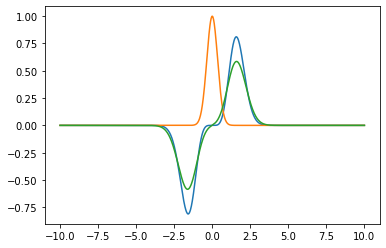

In [5]:
x = np.linspace(-10,10,1000)
y1 = x**5*np.exp(-x**2)
y2 = np.exp(-4*x**2)

Y1 = fftn(y1)
Y2 = fftn(y2)*(x[1]-x[0])
yy = fftshift(np.real(ifftn(Y1*Y2)))

plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, yy)
plt.show()

### パデ近似のデバッグ

100%|██████████| 29/29 [00:00<00:00, 12037.09it/s]


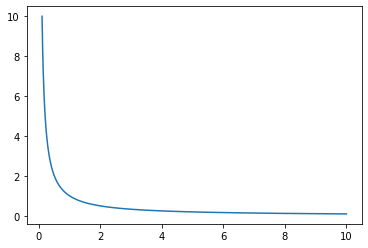

100%|██████████| 29/29 [00:00<00:00, 12706.03it/s]


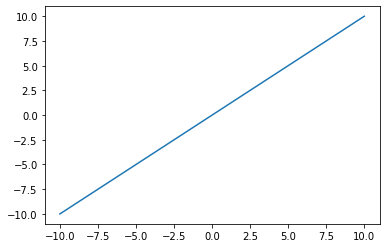

100%|██████████| 29/29 [00:00<00:00, 12526.76it/s]


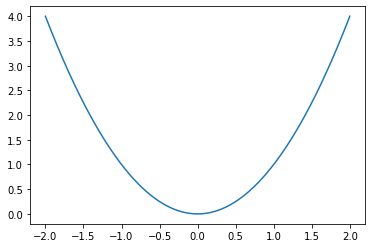

In [6]:
Nm = 256
Nm_cutoff=30

x = 1j *np.pi *np.arange(1, 2*Nm, 2)
y = 1/x[:,np.newaxis,np.newaxis]
xx = np.linspace(0.1, 10, 1000)
yy = pade_approx(y,x,xx,Nm_cutoff)
plt.plot(xx,np.real(yy).ravel())
plt.show()

x = 1j *np.pi *np.arange(1, 2*Nm, 2)
y = x[:,np.newaxis,np.newaxis]
xx = np.linspace(-10, 10, 1000)
yy = pade_approx(y,x,xx,Nm_cutoff)
plt.plot(xx,np.real(yy).ravel())
plt.show()

x = 1j *np.pi *np.arange(1, 2*Nm, 2)
y = (x**2)[:,np.newaxis,np.newaxis]
xx = np.linspace(-2, 2, 1000)
yy = pade_approx(y,x,xx,Nm_cutoff)
plt.plot(xx,np.real(yy).ravel())
plt.show()

## RPA のデバッグ

fortran のコードが RPAモードで相互作用のないグリーン関数を用いて計算しているので、それに合わせて Eliashberg_pipeline の引数を G0 にしている。  
実際に RPA + Eliashbeg を計算するときは G でよいと思う。

In [7]:
def RPA_pipeline(ENERGY, ENERGY_DIAG, U_charge, U_spin, mu_init, pm, mask=None):
    G0 = calc_Green(None, ENERGY, mu_init, *pm.calc_Green())
    G_tau_r = from_iwn_k_to_tau_r(G0)
    CHI0_tau_r = calc_chi0_tau_r(G_tau_r)
    if mask is not None:
        U_charge = mask.apply_mask(U_charge)
        U_spin = mask.apply_mask(U_spin)
        CHI0_tau_r = mask.apply_mask(CHI0_tau_r)
    CHI0, CHI_charge, CHI_spin = \
        calc_Susceptibilities(CHI0_tau_r, U_charge, U_spin, *pm.calc_Susceptibilities())
    V_Sigma = calc_V_effective(U_charge, U_spin, CHI0, CHI_charge, CHI_spin)
    V_Sigma_tau_r = from_iwn_k_to_tau_r(V_Sigma)
    if mask is not None:
        V_Sigma_tau_r = mask.restore(V_Sigma_tau_r)
    SIGMA = calc_Self_Energy(V_Sigma_tau_r, G_tau_r, *pm.calc_Self_Energy())
    mu = calc_mu(SIGMA, ENERGY, ENERGY_DIAG, *pm.calc_mu(), mu_init=mu_init)
    G = calc_Green(SIGMA, ENERGY, mu, *pm.calc_Green())
    return G0, CHI0, CHI_charge, CHI_spin, SIGMA, mu, G

### 2次元1軌道（ U=0.01 )

In [8]:
# 波数空間の分割数
Nqx = 16
Nqy = 16
Nqz = 1
# 松原周波数（これの2倍の点が使用される）
Nm = 512
# input file のサイトの位置ベクトルの本数
Nrvec = 5

# ユニットセルのサイト数
Nsite = 1
# サイト当たりの軌道の数 len(Norbit_each_site)=Nsite
Norbit_each_site = (1,)
# 軌道の総数 = sum(Norbit_each_site)
Norbit = 1
# 例: Nsite=2, Norbit_each_site=(2,3), Norbit=5 の時、orbit=0,1,...に対応する軌道は、
# site   orbit_each_site   orbit
#  0            0            0
#  0            1            1
#  1            0            2
#  1            1            3
#  1            2            4


# Nrvec*Norbit^2 行 4列の pandas DataFrame または numpy array の形式であればOK（列の名前は自由）
hopping_info_file = 'hop.dat'
hopping_df = pd.read_csv(hopping_info_file, sep='\s+', names=['x', 'y', 'z', 'hop', '-'])[:5]
hopping_df.drop('-', axis=1, inplace=True)
display(hopping_df)

temperature = 0.05
band_filling = 0.9
Uinner = 0.01     # 軌道内クーロン相互作用
Uinter = 0.     # 軌道間クーロン相互作用
Jhund = 0.      # フント結合
Jpair = 0.      # ペアホッピング
#V = 0.         # 異サイト軌道内クーロン相互作用（未実装）

#N_workers = cpu_count()

pm = parameter_manager(
    Nqx, Nqy, Nqz, Nm, Norbit, Norbit_each_site, Nrvec, Nsite, temperature, band_filling, Uinner, Uinter, Jhund, Jpair
)

,x,y,z,hop
0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0
2,-1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0
4,0.0,-1.0,0.0,1.0


In [9]:
ENERGY, ENERGY_DIAG, UNITARY = get_ENERGY(hopping_df, *pm.get_Energy())
U_charge, U_spin = get_INTERACTION(*pm.get_INTERACTION())
mu = calc_mu_non_interacting(ENERGY_DIAG, *pm.calc_mu_non_interacting())
print('chemical potential = {:.4g}'.format(mu))
G0, CHI0, CHI_charge, CHI_spin, SIGMA, mu, G = \
    RPA_pipeline(ENERGY, ENERGY_DIAG, U_charge, U_spin, mu, pm)
print('G0=', np.max(np.absolute(G0)))
print('chi0=', np.max(np.real(CHI0)))
print('chi_S=', np.max(np.real(CHI_spin)))
print('chi_C=', np.max(np.real(CHI_charge)))
print('Sigma=', np.max(np.absolute(SIGMA)))
print('chemical potential = {:.5g}'.format(mu))
print('G=', np.max(np.absolute(G)))

DELTA_init_gap = get_DELTA_band_init(*pm.get_DELTA_init(), gap_symmetry='random')
DELTA_init = from_band_to_orbit(DELTA_init_gap, UNITARY)
lambda_list, DELTA_list = Eliashberg_pipeline(G0, U_charge, U_spin, CHI_charge, CHI_spin, DELTA_init, pm)
print('lambda=', lambda_list[0])

chemical potential = -0.1045
G0= 6.091457250474281
chi0= 0.6480704495675643
chi_S= 0.6522977988450588
chi_C= 0.6438975398860702
Sigma= 2.9737229181786802e-06
chemical potential = -0.10454
G= 6.091431567447237
lambda= 3.244005249291646e-06


### 2次元1軌道 ( U=1 )

In [10]:
Nqx = 16
Nqy = 16
Nqz = 1
Nm = 512
Nrvec = 5

Nsite = 1
Norbit_each_site = (1,)
Norbit = 1

hopping_info_file = 'hop.dat'
hopping_df = pd.read_csv(hopping_info_file, sep='\s+', names=['x', 'y', 'z', 'hop', '-'])[:5]
hopping_df.drop('-', axis=1, inplace=True)
display(hopping_df)

temperature = 0.05
band_filling = 0.9
Uinner = 1.     # 軌道内クーロン相互作用
Uinter = 0.     # 軌道間クーロン相互作用
Jhund = 0.      # フント結合
Jpair = 0.      # ペアホッピング

pm = parameter_manager(
    Nqx, Nqy, Nqz, Nm, Norbit, Norbit_each_site, Nrvec, Nsite, temperature, band_filling, Uinner, Uinter, Jhund, Jpair
)

,x,y,z,hop
0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0
2,-1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0
4,0.0,-1.0,0.0,1.0


In [11]:
ENERGY, ENERGY_DIAG, UNITARY = get_ENERGY(hopping_df, *pm.get_Energy())
U_charge, U_spin = get_INTERACTION(*pm.get_INTERACTION())
mu = calc_mu_non_interacting(ENERGY_DIAG, *pm.calc_mu_non_interacting())
print('chemical potential = {:.4g}'.format(mu))
G0, CHI0, CHI_charge, CHI_spin, SIGMA, mu, G = \
    RPA_pipeline(ENERGY, ENERGY_DIAG, U_charge, U_spin, mu, pm)
print('G0=', np.max(np.absolute(G0)))
print('chi0=', np.max(np.real(CHI0)))
print('chi_S=', np.max(np.real(CHI_spin)))
print('chi_C=', np.max(np.real(CHI_charge)))
print('Sigma=', np.max(np.absolute(SIGMA)))
print('chemical potential = {:.5g}'.format(mu))
print('G=', np.max(np.absolute(G)))

DELTA_init_gap = get_DELTA_band_init(*pm.get_DELTA_init(), gap_symmetry='random')
DELTA_init = from_band_to_orbit(DELTA_init_gap, UNITARY)
lambda_list, DELTA_list = Eliashberg_pipeline(G0, U_charge, U_spin, CHI_charge, CHI_spin, DELTA_init, pm)
print('lambda=', lambda_list[0])

chemical potential = -0.1045
G0= 6.091457250474281
chi0= 0.6480704495675643
chi_S= 1.8414777865946284
chi_C= 0.39322982202466583
Sigma= 0.037032908153891
chemical potential = -0.12838
G= 5.603938312887815
lambda= 0.08309210959684486


### 2次元2サイト2軌道  (バンドが完全に重なっているので、2次元1軌道と同じ結果になるはず)

In [12]:
Nqx = 16
Nqy = 16
Nqz = 1
Nm = 512
Nrvec = 5

Nsite = 2
Norbit_each_site = (1,1)
Norbit = 2

hopping_info_file = 'hop.dat'
hopping_df = pd.read_csv(hopping_info_file, sep='\s+', names=['x', 'y', 'z', 'hop', '-'])
hopping_df.drop('-', axis=1, inplace=True)
hopping_df.loc[5,'hop'] = 0
hopping_df.loc[10,'hop'] = 0
display(hopping_df)

temperature = 0.05
band_filling = 0.9
Uinner = 1.     # 軌道内クーロン相互作用
Uinter = 0.     # 軌道間クーロン相互作用
Jhund = 0.      # フント結合
Jpair = 0.      # ペアホッピング

pm = parameter_manager(
    Nqx, Nqy, Nqz, Nm, Norbit, Norbit_each_site, Nrvec, Nsite, temperature, band_filling, Uinner, Uinter, Jhund, Jpair
)

,x,y,z,hop
0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0
2,-1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0
4,0.0,-1.0,0.0,1.0
5,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0
7,-1.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0
9,0.0,-1.0,0.0,0.0


In [13]:
ENERGY, ENERGY_DIAG, UNITARY = get_ENERGY(hopping_df, *pm.get_Energy())
U_charge, U_spin = get_INTERACTION(*pm.get_INTERACTION())
mu = calc_mu_non_interacting(ENERGY_DIAG, *pm.calc_mu_non_interacting())
print('chemical potential = {:.4g}'.format(mu))
G0, CHI0, CHI_charge, CHI_spin, SIGMA, mu, G = \
    RPA_pipeline(ENERGY, ENERGY_DIAG, U_charge, U_spin, mu, pm)
print('G0=', np.max(np.absolute(G0)))
print('chi0=', np.max(np.real(CHI0)))
print('chi_S=', np.max(np.real(CHI_spin)))
print('chi_C=', np.max(np.real(CHI_charge)))
print('Sigma=', np.max(np.absolute(SIGMA)))
print('chemical potential = {:.5g}'.format(mu))
print('G=', np.max(np.absolute(G)))

DELTA_init_gap = get_DELTA_band_init(*pm.get_DELTA_init(), gap_symmetry='random')
DELTA_init = from_band_to_orbit(DELTA_init_gap, UNITARY)
lambda_list, DELTA_list = Eliashberg_pipeline(G0, U_charge, U_spin, CHI_charge, CHI_spin, DELTA_init, pm)
print('lambda=', lambda_list[0])

chemical potential = -0.1045
G0= 6.091457250474281
chi0= 0.6480704495675647
chi_S= 1.841477786594631
chi_C= 0.6480704495675647
Sigma= 0.03703290815389101
chemical potential = -0.12838
G= 5.603938312887738
lambda= 0.08309210959684478


### 2次元2サイト2軌道  ( 2層系 )

In [14]:
Nqx = 16
Nqy = 16
Nqz = 1
Nm = 512
Nrvec = 5

Nsite = 2
Norbit_each_site = (1,1)
Norbit = 2

hopping_info_file = 'hop.dat'
hopping_df = pd.read_csv(hopping_info_file, sep='\s+', names=['x', 'y', 'z', 'hop', '-'])
hopping_df.drop('-', axis=1, inplace=True)
display(hopping_df)

temperature = 0.05
band_filling = 0.9
Uinner = 1.     # 軌道内クーロン相互作用
Uinter = 0.     # 軌道間クーロン相互作用
Jhund = 0.      # フント結合
Jpair = 0.      # ペアホッピング

pm = parameter_manager(
    Nqx, Nqy, Nqz, Nm, Norbit, Norbit_each_site, Nrvec, Nsite, temperature, band_filling, Uinner, Uinter, Jhund, Jpair
)

,x,y,z,hop
0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0
2,-1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0
4,0.0,-1.0,0.0,1.0
5,0.0,0.0,0.0,2.0
6,1.0,0.0,0.0,0.0
7,-1.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0
9,0.0,-1.0,0.0,0.0


In [15]:
ENERGY, ENERGY_DIAG, UNITARY = get_ENERGY(hopping_df, *pm.get_Energy())
U_charge, U_spin = get_INTERACTION(*pm.get_INTERACTION())
mu = calc_mu_non_interacting(ENERGY_DIAG, *pm.calc_mu_non_interacting())
print('chemical potential = {:.4g}'.format(mu))
G0, CHI0, CHI_charge, CHI_spin, SIGMA, mu, G = \
    RPA_pipeline(ENERGY, ENERGY_DIAG, U_charge, U_spin, mu, pm)
print('G0=', np.max(np.absolute(G0)))
print('chi0=', np.max(np.real(CHI0)))
print('chi_S=', np.max(np.real(CHI_spin)))
print('chi_C=', np.max(np.real(CHI_charge)))
print('Sigma=', np.max(np.absolute(SIGMA)))
print('chemical potential = {:.5g}'.format(mu))
print('G=', np.max(np.absolute(G)))

DELTA_init_gap = get_DELTA_band_init(*pm.get_DELTA_init(), gap_symmetry='random')
DELTA_init = from_band_to_orbit(DELTA_init_gap, UNITARY)
lambda_list, DELTA_list = Eliashberg_pipeline(G0, U_charge, U_spin, CHI_charge, CHI_spin, DELTA_init, pm)
print('lambda=', lambda_list[0])

chemical potential = -0.5174
G0= 3.086149898864834
chi0= 0.18350106506435193
chi_S= 0.24685696325883155
chi_C= 0.18310065219171695
Sigma= 0.022400593900293937
chemical potential = -0.5222
G= 3.0604247251004604
lambda= 0.024660230694555196


### 2次元2サイト2軌道  (バンドが完全に重なっているので、2次元1軌道と同じ結果になるはず)

In [16]:
Nqx = 16
Nqy = 16
Nqz = 1
Nm = 512
Nrvec = 5

Nsite = 1
Norbit_each_site = (2,)
Norbit = 2

hopping_info_file = 'hop.dat'
hopping_df = pd.read_csv(hopping_info_file, sep='\s+', names=['x', 'y', 'z', 'hop', '-'])
hopping_df.drop('-', axis=1, inplace=True)
hopping_df.loc[5,'hop'] = 0
hopping_df.loc[10,'hop'] = 0
display(hopping_df)

temperature = 0.05
band_filling = 0.9
Uinner = 1.     # 軌道内クーロン相互作用
Uinter = 0.     # 軌道間クーロン相互作用
Jhund = 0.      # フント結合
Jpair = 0.      # ペアホッピング

pm = parameter_manager(
    Nqx, Nqy, Nqz, Nm, Norbit, Norbit_each_site, Nrvec, Nsite, temperature, band_filling, Uinner, Uinter, Jhund, Jpair
)

,x,y,z,hop
0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0
2,-1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0
4,0.0,-1.0,0.0,1.0
5,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0
7,-1.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0
9,0.0,-1.0,0.0,0.0


In [17]:
ENERGY, ENERGY_DIAG, UNITARY = get_ENERGY(hopping_df, *pm.get_Energy())
U_charge, U_spin = get_INTERACTION(*pm.get_INTERACTION())
mu = calc_mu_non_interacting(ENERGY_DIAG, *pm.calc_mu_non_interacting())
print('chemical potential = {:.4g}'.format(mu))
G0, CHI0, CHI_charge, CHI_spin, SIGMA, mu, G = \
    RPA_pipeline(ENERGY, ENERGY_DIAG, U_charge, U_spin, mu, pm)
print('G0=', np.max(np.absolute(G0)))
print('chi0=', np.max(np.real(CHI0)))
print('chi_S=', np.max(np.real(CHI_spin)))
print('chi_C=', np.max(np.real(CHI_charge)))
print('Sigma=', np.max(np.absolute(SIGMA)))
print('chemical potential = {:.5g}'.format(mu))
print('G=', np.max(np.absolute(G)))

DELTA_init_gap = get_DELTA_band_init(*pm.get_DELTA_init(), gap_symmetry='random')
DELTA_init = from_band_to_orbit(DELTA_init_gap, UNITARY)
lambda_list, DELTA_list = Eliashberg_pipeline(G0, U_charge, U_spin, CHI_charge, CHI_spin, DELTA_init, pm)
print('lambda=', lambda_list[0])

chemical potential = -0.1045
G0= 6.091457250474281
chi0= 0.6480704495675647
chi_S= 1.841477786594631
chi_C= 0.6480704495675647
Sigma= 0.03703290815389101
chemical potential = -0.12838
G= 5.603938312887738
lambda= 0.08309210959684478


### 2次元1サイト2軌道 (異軌道間の相互作用が 0 なので、2次元2サイト2軌道と同じになるはず)

In [18]:
Nqx = 16
Nqy = 16
Nqz = 1
Nm = 512
Nrvec = 5

Nsite = 1
Norbit_each_site = (2,)
Norbit = 2

hopping_info_file = 'hop.dat'
hopping_df = pd.read_csv(hopping_info_file, sep='\s+', names=['x', 'y', 'z', 'hop', '-'])
hopping_df.drop('-', axis=1, inplace=True)
display(hopping_df)

temperature = 0.05
band_filling = 0.9
Uinner = 1.     # 軌道内クーロン相互作用
Uinter = 0.     # 軌道間クーロン相互作用
Jhund = 0.      # フント結合
Jpair = 0.      # ペアホッピング

pm = parameter_manager(
    Nqx, Nqy, Nqz, Nm, Norbit, Norbit_each_site, Nrvec, Nsite, temperature, band_filling, Uinner, Uinter, Jhund, Jpair
)

,x,y,z,hop
0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0
2,-1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0
4,0.0,-1.0,0.0,1.0
5,0.0,0.0,0.0,2.0
6,1.0,0.0,0.0,0.0
7,-1.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0
9,0.0,-1.0,0.0,0.0


In [19]:
ENERGY, ENERGY_DIAG, UNITARY = get_ENERGY(hopping_df, *pm.get_Energy())
U_charge, U_spin = get_INTERACTION(*pm.get_INTERACTION())
mu = calc_mu_non_interacting(ENERGY_DIAG, *pm.calc_mu_non_interacting())
print('chemical potential = {:.4g}'.format(mu))
G0, CHI0, CHI_charge, CHI_spin, SIGMA, mu, G = \
    RPA_pipeline(ENERGY, ENERGY_DIAG, U_charge, U_spin, mu, pm)
print('G0=', np.max(np.absolute(G0)))
print('chi0=', np.max(np.real(CHI0)))
print('chi_S=', np.max(np.real(CHI_spin)))
print('chi_C=', np.max(np.real(CHI_charge)))
print('Sigma=', np.max(np.absolute(SIGMA)))
print('chemical potential = {:.5g}'.format(mu))
print('G=', np.max(np.absolute(G)))

DELTA_init_gap = get_DELTA_band_init(*pm.get_DELTA_init(), gap_symmetry='random')
DELTA_init = from_band_to_orbit(DELTA_init_gap, UNITARY)
lambda_list, DELTA_list = Eliashberg_pipeline(G0, U_charge, U_spin, CHI_charge, CHI_spin, DELTA_init, pm)
print('lambda=', lambda_list[0])

chemical potential = -0.5174
G0= 3.086149898864834
chi0= 0.18350106506435193
chi_S= 0.24685696325883155
chi_C= 0.18310065219171695
Sigma= 0.022400593900293937
chemical potential = -0.5222
G= 3.0604247251004604
lambda= 0.024660230694555196


### マスキングあり

自己エネルギーやグリーン関数の計算をするのに必要のない要素を削除して計算している。  
CHI0, CHI_spin, CHI_charge が知りたいときはマスキングなしで計算する必要がある。

In [20]:
ENERGY, ENERGY_DIAG, UNITARY = get_ENERGY(hopping_df, *pm.get_Energy())
U_charge, U_spin = get_INTERACTION(*pm.get_INTERACTION())
mask = mkmask(U_charge, U_spin)
mu = calc_mu_non_interacting(ENERGY_DIAG, *pm.calc_mu_non_interacting())
print('chemical potential = {:.4g}'.format(mu))
G0, CHI0, CHI_charge, CHI_spin, SIGMA, mu, G = \
    RPA_pipeline(ENERGY, ENERGY_DIAG, U_charge, U_spin, mu, pm, mask=mask)
print('G0=', np.max(np.absolute(G0)))
print('chi0=', np.max(np.real(CHI0)))
print('chi_S=', np.max(np.real(CHI_spin)))
print('chi_C=', np.max(np.real(CHI_charge)))
print('Sigma=', np.max(np.absolute(SIGMA)))
print('chemical potential = {:.5g}'.format(mu))
print('G=', np.max(np.absolute(G)))

DELTA_init_gap = get_DELTA_band_init(*pm.get_DELTA_init(), gap_symmetry='random')
DELTA_init = from_band_to_orbit(DELTA_init_gap, UNITARY)
lambda_list, DELTA_list = \
    Eliashberg_pipeline(G0, U_charge, U_spin, CHI_charge, CHI_spin, DELTA_init, pm, mask=mask)
print('lambda=', lambda_list[0])

chemical potential = -0.5174
G0= 3.086149898864834
chi0= 0.1835010650643519
chi_S= 0.24685696325883155
chi_C= 0.14785535562383564
Sigma= 0.022400593900293937
chemical potential = -0.5222
G= 3.0604247251004604
lambda= 0.024660230694555196


lambda= 0.024381736696696063


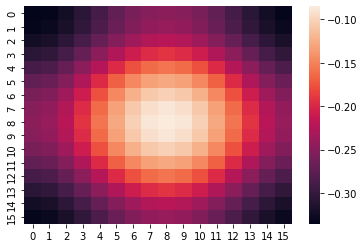

lambda= 0.006460148877597665


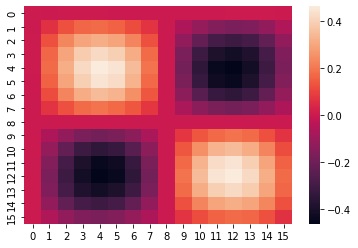

lambda= 0.0036280002579062815


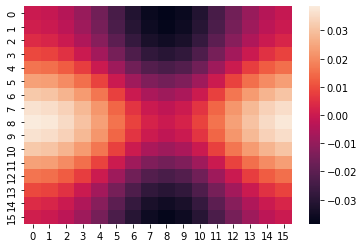

In [21]:
# 相互作用のあるグリーン関数を使用している
DELTA_init_gap = get_DELTA_band_init(*pm.get_DELTA_init(), gap_symmetry='random')
DELTA_init = from_band_to_orbit(DELTA_init_gap, UNITARY)
lambda_list, DELTA_list = \
    Eliashberg_pipeline(G, U_charge, U_spin, CHI_charge, CHI_spin, DELTA_init, pm, mask=mask, k=3)
print('lambda=', lambda_list[0])
sns.heatmap(np.sum(np.real(from_orbit_to_band(DELTA_list[0], UNITARY)), axis=0)[:,:,0,0,0])
plt.show()
print('lambda=', lambda_list[1])
sns.heatmap(np.sum(np.real(from_orbit_to_band(DELTA_list[1], UNITARY)), axis=0)[:,:,0,0,0])
plt.show()
print('lambda=', lambda_list[2])
sns.heatmap(np.sum(np.imag(from_orbit_to_band(DELTA_list[2], UNITARY)), axis=0)[:,:,0,0,0])
plt.show()

### Pade 近似

In [22]:
Nqx = 64
Nqy = 64
Nqz = 1
Nm = 512
Nrvec = 5

Nsite = 1
Norbit_each_site = (2,)
Norbit = 2

hopping_info_file = 'hop.dat'
hopping_df = pd.read_csv(hopping_info_file, sep='\s+', names=['x', 'y', 'z', 'hop', '-'])
hopping_df.drop('-', axis=1, inplace=True)
display(hopping_df)

temperature = 0.05
band_filling = 0.9
Uinner = 1.     # 軌道内クーロン相互作用
Uinter = 0.     # 軌道間クーロン相互作用
Jhund = 0.      # フント結合
Jpair = 0.      # ペアホッピング

pm = parameter_manager(
    Nqx, Nqy, Nqz, Nm, Norbit, Norbit_each_site, Nrvec, Nsite, temperature, band_filling, Uinner, Uinter, Jhund, Jpair
)

,x,y,z,hop
0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0
2,-1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0
4,0.0,-1.0,0.0,1.0
5,0.0,0.0,0.0,2.0
6,1.0,0.0,0.0,0.0
7,-1.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0
9,0.0,-1.0,0.0,0.0


In [23]:
ENERGY, ENERGY_DIAG, UNITARY = get_ENERGY(hopping_df, *pm.get_Energy())
U_charge, U_spin = get_INTERACTION(*pm.get_INTERACTION())
mask = mkmask(U_charge, U_spin)
mu = calc_mu_non_interacting(ENERGY_DIAG, *pm.calc_mu_non_interacting())
print('chemical potential = {:.4g}'.format(mu))
G0, CHI0, CHI_charge, CHI_spin, SIGMA, mu, G = \
    RPA_pipeline(ENERGY, ENERGY_DIAG, U_charge, U_spin, mu, pm, mask=mask)
print('G0=', np.max(np.absolute(G0)))
print('chi0=', np.max(np.real(CHI0)))
print('chi_S=', np.max(np.real(CHI_spin)))
print('chi_C=', np.max(np.real(CHI_charge)))
print('Sigma=', np.max(np.absolute(SIGMA)))
print('chemical potential = {:.5g}'.format(mu))
print('G=', np.max(np.absolute(G)))

chemical potential = -0.4555
G0= 3.191471053487824
chi0= 0.19530872397305413
chi_S= 0.2729433100868184
chi_C= 0.15429362557229684
Sigma= 0.022438263977236982
chemical potential = -0.46036
G= 3.1380593816182882


100%|██████████| 49/49 [00:12<00:00,  3.94it/s]


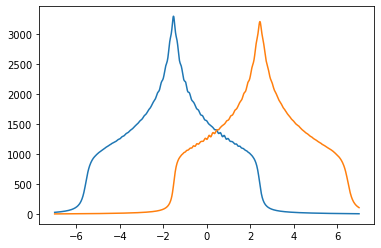

In [24]:
idelta = 0.1j
Neps = 1001
epsilon = np.linspace(-7,7,Neps)

G_band = from_orbit_to_band(G, UNITARY)
G_R = pade_approx(G_band, pm.matsubara_half, epsilon+idelta, Nm_cutoff=50)
A_spec = -np.imag(G_R)

DOS0 = np.sum(A_spec, axis=(1,2,3))[:,0,0]
DOS1 = np.sum(A_spec, axis=(1,2,3))[:,1,1]

plt.plot(np.real(epsilon), DOS0)
plt.plot(np.real(epsilon), DOS1)
plt.show()